In [21]:
import random 

import joblib

import sys
sys.path.append('../..')

#from utils import load_cinema_reviews

import random
random.seed(42)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plot
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_selection import chi2
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, precision_recall_curve

from tensorflow import keras
from tensorflow.keras import layers



import matplotlib.pyplot as plt

Cagamos todas las variables que se van a plotear o analizar

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [30]:
grid = joblib.load('/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/logistic_grid.pkl')
history = joblib.load('/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/history.pkl')

mlp = keras.models.load_model('/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/mlp.h5')

X_train = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/X_train.txt")
X_train = X_train.drop(columns= "Unnamed: 0")
y_train = np.loadtxt("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/y_train.txt")

X_test = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/X_test.txt")
y_test = np.loadtxt("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/y_test.txt")

cv = joblib.load ("/content/drive/MyDrive/Colab_Notebooks/Proyecto_NLP/tfidf.pickle")

In [15]:
X_test = X_test.drop(columns= "Unnamed: 0")

Empezamos analizando los resultados de la regresion logistica en Test

In [16]:
test_predict = grid.predict(X_test)
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, test_predict)))
print('\nClassification report:\n{}'.format(classification_report(y_test, test_predict)))
print('Accuracy score:{}'.format(accuracy_score(y_test, test_predict)))

Confussion matrix:
[[6209  927]
 [ 894 6228]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.87      0.87      0.87      7136
         1.0       0.87      0.87      0.87      7122

    accuracy                           0.87     14258
   macro avg       0.87      0.87      0.87     14258
weighted avg       0.87      0.87      0.87     14258

Accuracy score:0.8722822275213915


El modelo de regresión logistica parece desempeñar bastante bien. Los valores de precisión, recall, f1-score y accuracy son iguales, lo que indica que el modelo es consistente en la clasificación de ambos tipos de clase (clasifica igual de bien las reviews positivas que las negativas). Esto quiere decir que nuestro modelo ha aprendido a generalizar.

Se podría jugar con el umbral de la regresion logistica (actualmente en 0.5) para reducir el número de falsos positivos. Consideramos que el modelo se ha creado con el objetivo de discriminar las reviews negativas para asi manipularlas posteriormente y obtener información sobre lo que falla en el producto.

El siguiente paso será valorar el modelo de red neuronal en Test

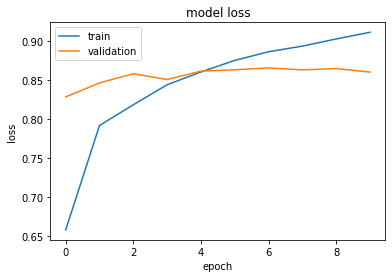

In [18]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.axis([0, 20, 0.6, 1])
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

En el plot de arriba se muestra como progresa el entrenamiento y las predicciones (de validación) con el número de épocas entrenadas. A pesar de iterar sobre diferentes modelos, no se ha conseguido modificar los resultados de validación significamente con el número de épocas, mientras que los resultados de entrenamiento no cesan de crecer pudiendo incurrir en overfitting. Por esto, se ha optado por entrenar el modelo unicamente durante 10 epocas.

In [25]:
y_hat = mlp.predict(X_test)
for i in range(len(y_hat)):
  if y_hat[i] > 0.5:
    y_hat[i] = 1
  else:
    y_hat[i] = 0

In [26]:
print('Confussion matrix:\n{}'.format(confusion_matrix(y_test, y_hat)))
print('\nClassification report:\n{}'.format(classification_report(y_test, y_hat)))
print('Accuracy score:{}'.format(accuracy_score(y_test, y_hat)))

Confussion matrix:
[[6522  614]
 [1434 5688]]

Classification report:
              precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      7136
         1.0       0.90      0.80      0.85      7122

    accuracy                           0.86     14258
   macro avg       0.86      0.86      0.86     14258
weighted avg       0.86      0.86      0.86     14258

Accuracy score:0.856361341001543


El modelo mlp parece tener menos consistencia que la regresion logistica. Predice mejor las reviews negativas ( y en consecuencia el numero de falsos positivos es menor) pero predice peor las reviews positivas. Como asumimos que la funcionalidad del modelo es predecir las negativas, tomamos este modelo como la referencia. Además si lo deseamos podemos mover el umbral de decisión a valores como 0.6 - 0.7 para dismunuir aun más los falsos positivos.

Por ultimo vamos a comparar ciertas métricas de test con las métricas de entrenamiento para ver que tal generaliza nuestro modelo

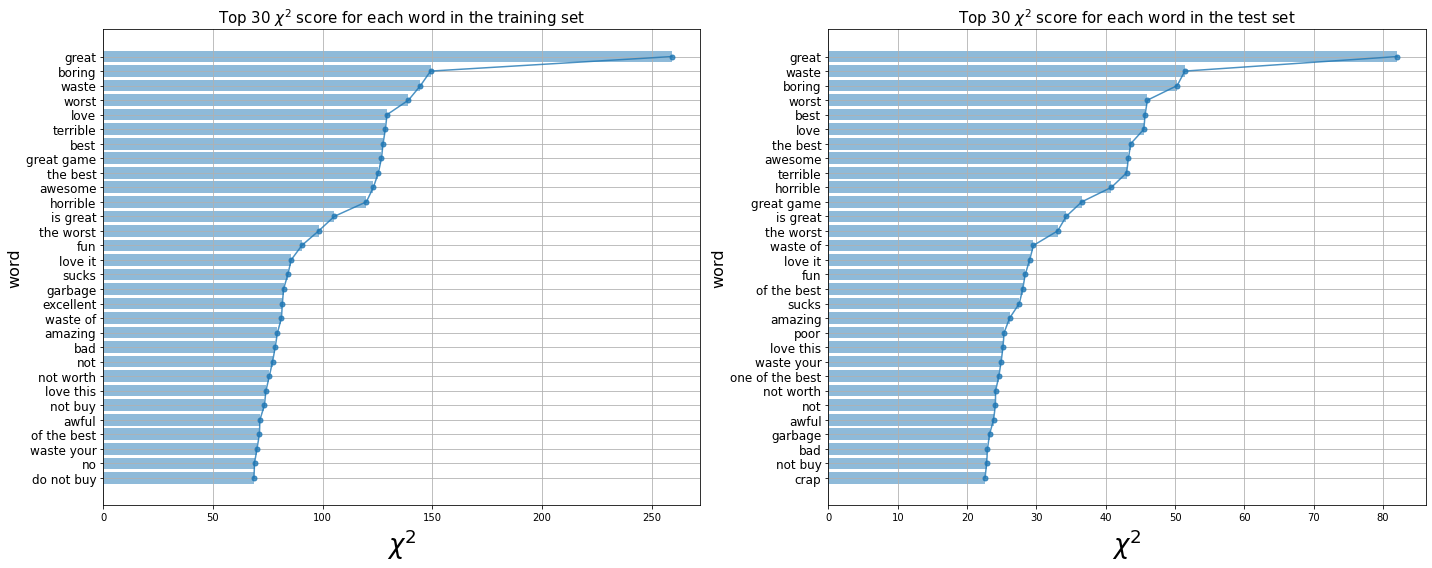

In [59]:
#Temporal

i = 30

#train
chi2score_train = chi2(X_train, y_train)[0]
scores_train = list(zip(cv.get_feature_names(), chi2score_train))
sorted_scores_train = sorted(scores_train, key=lambda x:x[1])
topchi2_train = list(zip(*sorted_scores_train[-i:]))
x_train = range(len(topchi2_train[1]))
labels_train = topchi2_train[0]
#test
chi2score_test = chi2(X_test, y_test)[0]
scores_test = list(zip(cv.get_feature_names(), chi2score_test))
sorted_scores_test = sorted(scores_test, key=lambda x:x[1])
topchi2_test = list(zip(*sorted_scores_test[-i:]))
x_test = range(len(topchi2_test[1]))
labels_test = topchi2[0]


plt.figure(figsize=(20, 8))  

plt.subplot(1,2,1)
plt.barh(x_train,topchi2_train[1], align='center', alpha=0.5)
plt.plot(topchi2_train[1], x_train, '-o', markersize=5, alpha=0.8)
plt.yticks(x_train, labels_train, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the training set'.format(i), fontsize=15)
plt.grid()
plt.tight_layout()


plt.subplot(1,2,2)
plt.barh(x_test,topchi2_test[1], align='center', alpha=0.5)
plt.plot(topchi2_test[1], x_test, '-o', markersize=5, alpha=0.8)
plt.yticks(x_test, labels_test, fontsize=12)
plt.xlabel('$\chi^2$', fontsize=26)
plt.ylabel('word', fontsize=16)
plt.title('Top {} $\chi^2$ score for each word in the test set'.format(i), fontsize=15)
plt.grid()
plt.tight_layout()
plt.show();

Observando ambos graficos de chi2, podemos afirmar que en general nuestro vocabulario generaliza bien, ya que tanto en train como en test los ngramas con mayor chi2 son los mismos. 

### Conclusiones y trabajo futuro

El modelo entrenado tiene una precisión del 85% para determinar si una review tiene polaridad negativa o positiva. Respecto al recall en cuanto a reviews negativas, que es el valor que consideramos clave en este modelo, el valor asciende hasta el 91%.

En general se puede afirmar que el modelo desempeña bien aunque sería deseable aumentar la precisión y sobretodo aumentar el recall hacia valores cercanos al 95%. Para mejorar el modelo se proponen los siguientes caminos:



1.   Hacer un análisis más detallado del vocabulario y de las stopwords. ¿Son las stopwords incluidas en la vectorización realmente despreciables? ¿Hay alguna más que se pudiese haber incluido? Una buena forma para esto sería hacer una vectorización con un vocabulario mucho más amplio (y otro más reducido) y ver como desempeña el modelo. Otra opción es hacer un análisis más individual de las stopwords incluidas para ver si hay alguna que se pueda reincluir en el vocabulario variando los valores de df_max y df_min.

2.   Otra forma de eliminar stopwords y facilitar el entrenamiento de problemas sería mediante un NER para así descartar palabras que por su condición sintactica no tienen influencia en la polaridad (nombres, lugares, siglas....)

3. Se podrían probar otros modelos como random forest para ver si el modelo desempeña mejor.

